In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df =pd.read_csv('https://raw.githubusercontent.com/wan6570/FlyAI_Project/main/Data/ProcessedData/LCK_2023_SUMMER_DROP_NAN.csv')

In [6]:
df.head()

Player   Champion     Role  Level  Kills  Deaths  Assists  KDA   CS  \
0     Kiin  Gangplank      TOP     16      2       1        8   10  252   
1     Cuzz      Viego   JUNGLE     15      8       2       10    9  182   
2      Bdd       Ahri      MID     15      7       3       10  5.7  219   
3   Aiming   Tristana      ADC     15      0       2       13  6.5  264   
4  Lehends    Alistar  SUPPORT     12      2       3       11  4.3   30   

   CS in Jungle  ...  Total damage taken  Total Time Spent Dead  \
0           4.0  ...             13570.0                     42   
1         156.0  ...             23779.0                     66   
2           0.0  ...             16177.0                    114   
3          12.0  ...              9404.0                     33   
4           0.0  ...             11572.0                     49   

   Consumables purchased  Items Purchased  Shutdown bounty collected  \
0                      7               22                          0   
1                      5               24                          0   
2                      7               23                        100   
3                      6               23                          0   
4                     16               27                          0   

   Shutdown bounty lost  Version      Date  Team  Result  
0                   100    13.14  8/6/2023    KT     Win  
1                   150    13.14  8/6/2023    KT     Win  
2                   500    13.14  8/6/2023    KT     Win  
3                     0    13.14  8/6/2023    KT     Win  
4                     0    13.14  8/6/2023    KT     Win  

[5 rows x 60 columns]

In [3]:
# Filter players who have participated in more than 25 games
player_counts = df['Player'].value_counts()
players_to_keep = player_counts[player_counts > 20].index
df_filtered = df[df['Player'].isin(players_to_keep)]

# Split the dataframe based on the "Role" column
role_groups = df_filtered.groupby('Role')
role_dfs = {role: role_group for role, role_group in role_groups}

# Adjust XPD@15 for each role so that its minimum value is 50
adjustments = {role: 50 - df['XPD@15'].min() for role, df in role_dfs.items()}
for role, adjustment in adjustments.items():
    role_dfs[role]['XPD@15'] += adjustment

# Function to normalize stats for each role
def normalize_role_stats(role_df):
    role_avg_stats = role_df[['GPM', 'VSPM', 'DPM', 'KP%', 'XPD@15']].mean()
    player_avg_stats = role_df.groupby('Player')[['GPM', 'VSPM', 'DPM', 'KP%', 'XPD@15']].mean()
    normalized_stats = player_avg_stats / role_avg_stats
    return normalized_stats

# Calculate normalized stats for each role
normalized_stats_adjusted = {role: normalize_role_stats(df[df['Result'] == 'Win']) for role, df in role_dfs.items()}

In [6]:
combined_df = pd.concat(normalized_stats_adjusted).reset_index()
combined_df.columns = ['Role', 'Player', 'GPM', 'VSPM', 'DPM', 'KP%', 'XPD@15']

combined_df.to_csv('FiveFeatures.csv', index=True)

In [17]:
for role in normalized_stats_adjusted.keys():
    temp = pd.DataFrame(normalized_stats_adjusted[role])
    temp.to_csv(f'{role}_FiveFeatures.csv')


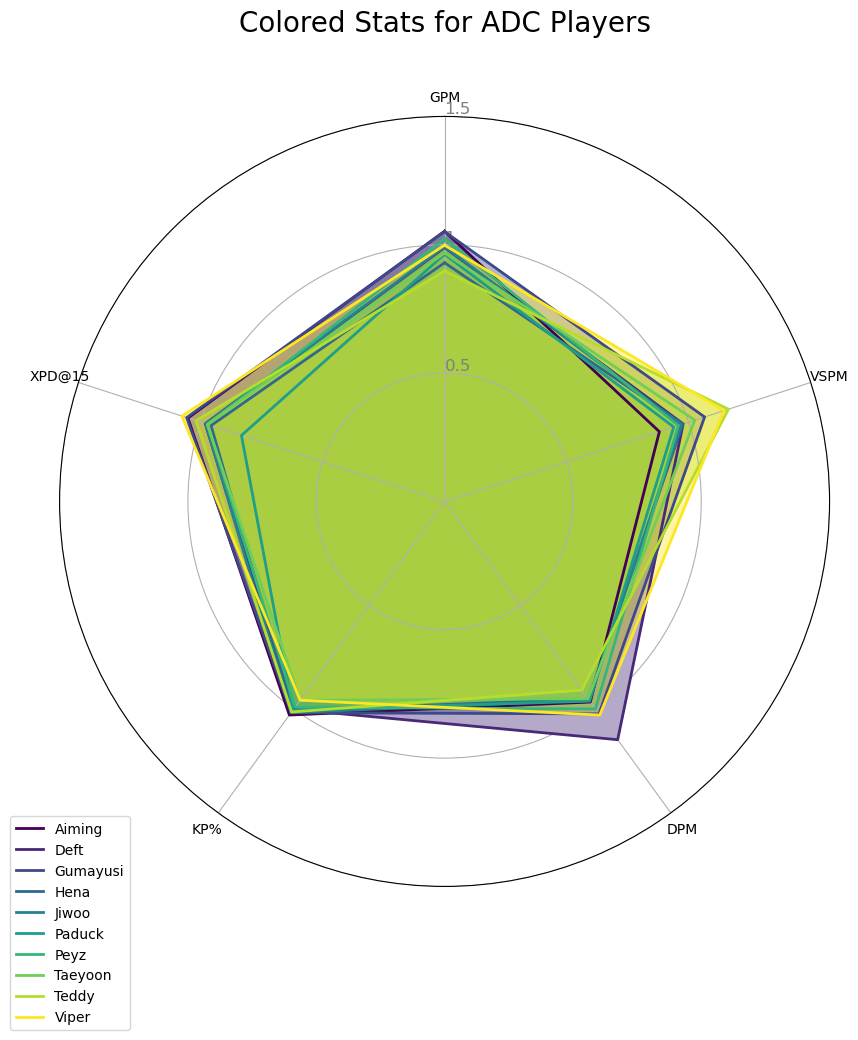

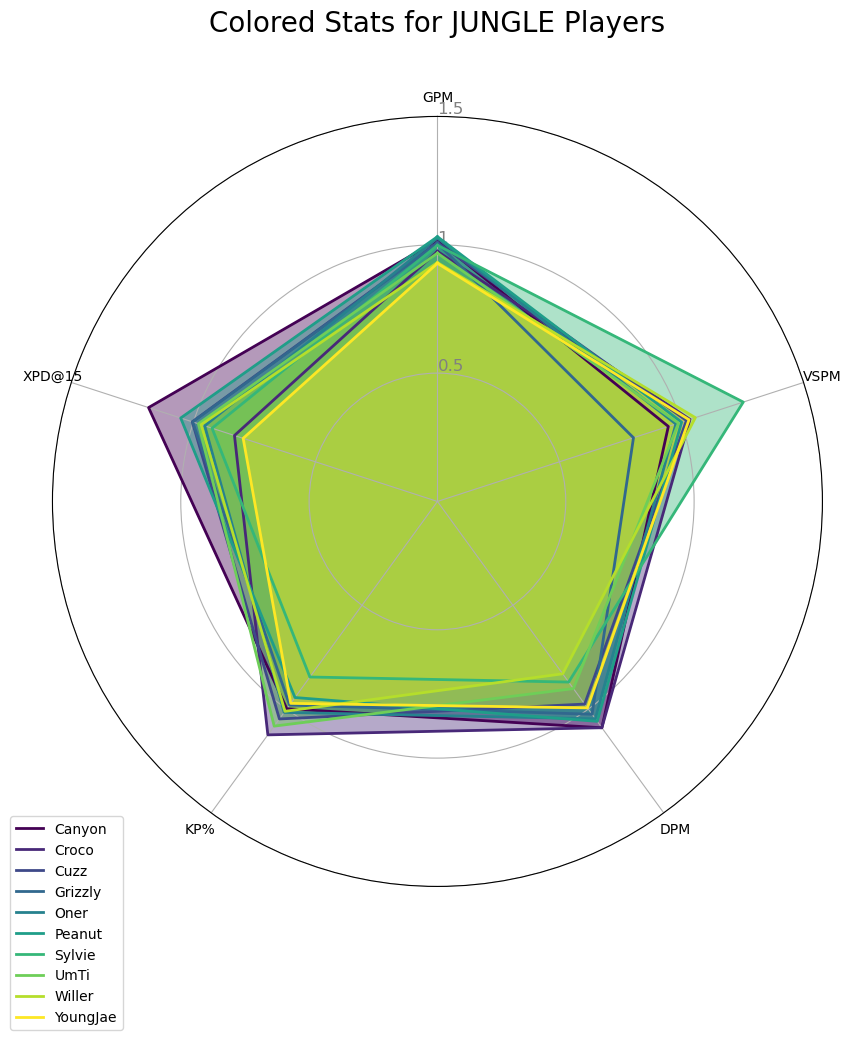

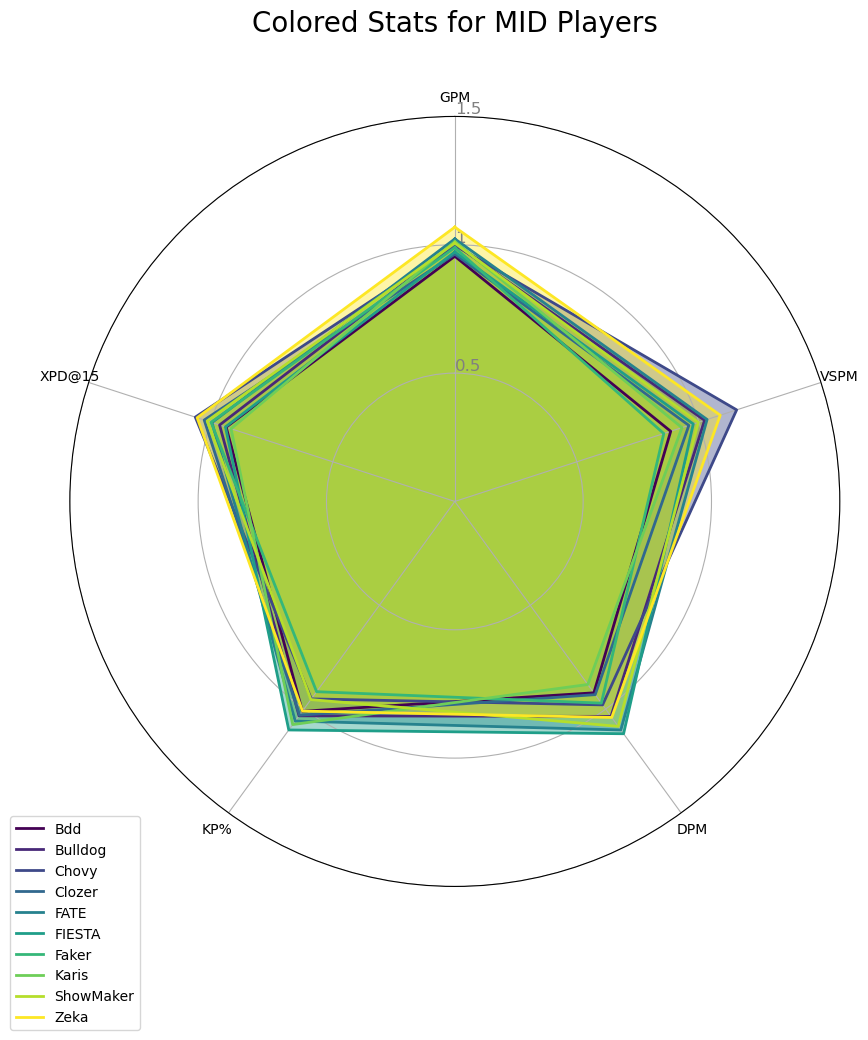

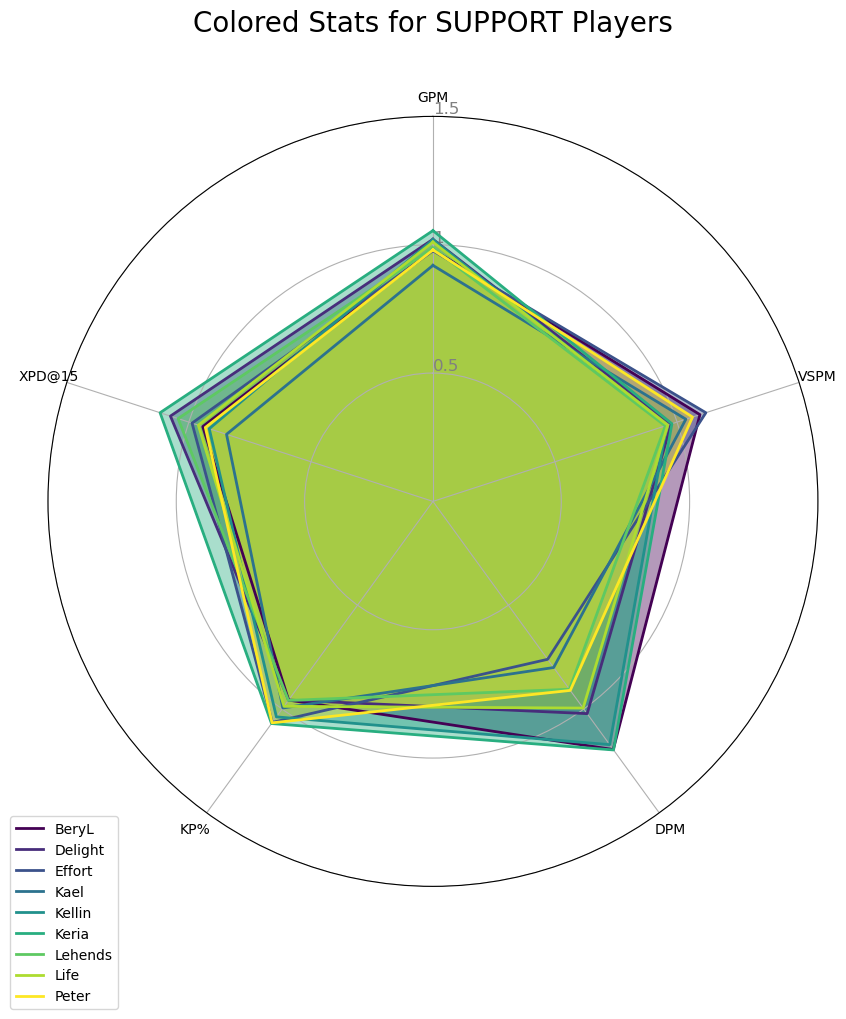

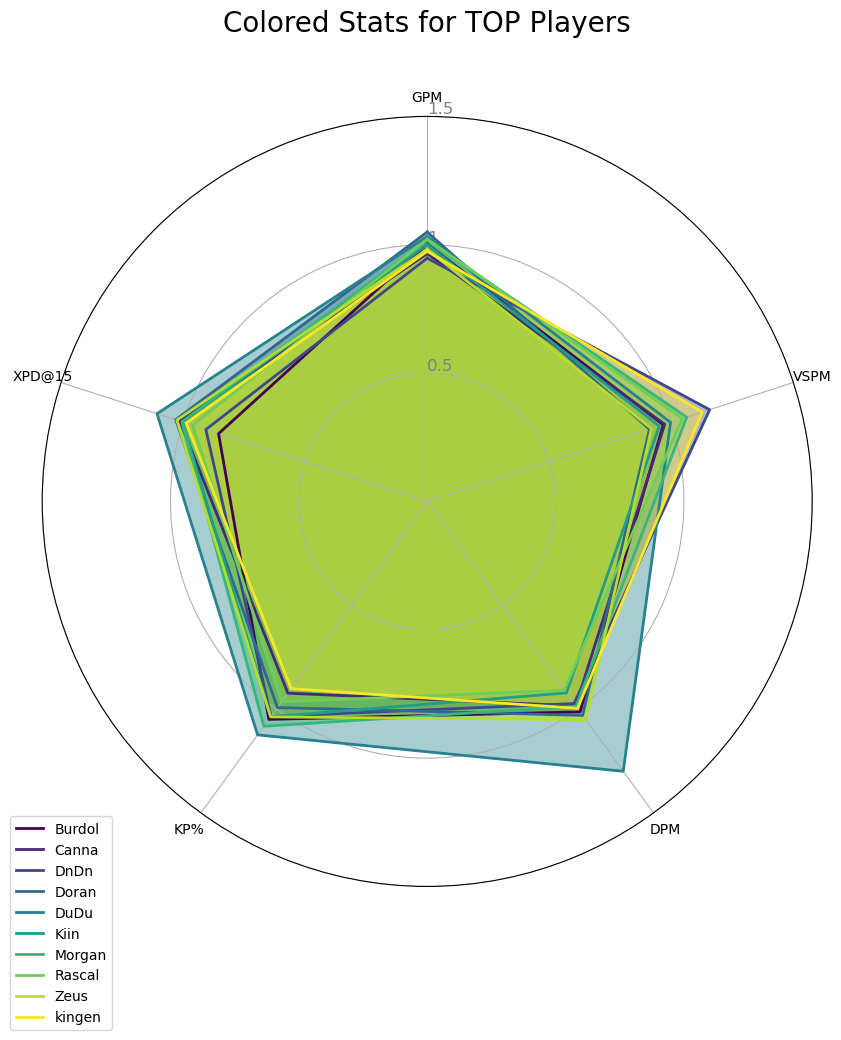

In [12]:
# Function to plot radar chart for the stats
def plot_colored_radar(data, title=""):
    categories = list(data)
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    plt.xticks(angles[:-1], categories)
    ax.set_rlabel_position(0)
    plt.yticks([0.5, 1, 1.5], ["0.5", "1", "1.5"], color="grey", size=12)
    plt.ylim(0, 1.5)
    colors = plt.cm.viridis(np.linspace(0, 1, len(data)))
    for i, (player, row) in enumerate(data.iterrows()):
        values = row.values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=player, color=colors[i])
        ax.fill(angles, values, color=colors[i], alpha=0.4)
    plt.title(title, size=20, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

# Plot the radar chart for all roles
for role, stats in normalized_stats_adjusted.items():
    plot_colored_radar(stats, title=f"Colored Stats for {role} Players")